ID: 225742020 

In [39]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

import pandas as pd
import os, sys
import re
import string
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,7.27)})


import fire

import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor



In [127]:
class tweetSearch():
    '''
    This is a basic class to search and download twitter data.
    '''
    def __init__(self, handle,cols=None,auth=None):
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'text','lang',
                    'favorite_count', 'retweet_count', 'original_author', 'hashtags', 
                    'user_mentions', 'location']
            
        if auth is None:
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('CONSUMER_KEY' or 'TWITTER_API_KEY')
            consumer_secret = os.environ.get('CONSUMER_SECRET' or 'TWITTER_API_SECRET')
            access_token = os.environ.get('ACCESS_TOKEN' or 'TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('ACCESS_TOKEN_SECRET' or 'TWITTER_ACCESS_TOKEN_SECRET')


            #This handles Twitter authentication and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
                                
        self.auth = auth
        self.api = tweepy.API(auth)    
        
        self.handle = handle
            

    def get_tweets(self, csvfile=None):
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
        
        retweets = 0
        likes = 0
        p_score = 0
        scores = []
        for item in Cursor(self.api.user_timeline, id=self.handle).items(150):
                       
            status = item._json
            new_entry = []
            
            
            if (not status['retweeted']) and ('RT @' not in status['text']): #filter out RTs.
                retweets += status['retweet_count']
                likes += status['favorite_count']
                

                new_entry += [status['id'], status['created_at'],
                                  status['source'], status['text'], status['lang'],
                                  status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags


                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append mentions

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                
                new_entry.append(location)

                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        p_score = retweets + likes
        relevance = (retweets/200)*100
        scores = [p_score, relevance]
        
        #Reset count
        retweets, likes = 0, 0
        
        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
        
        return scores

    
    def get_reach(self):
        item = self.api.get_user(self.handle)
        followers = item.followers_count
        following = item.friends_count
        
        reach_score = followers - following
        return reach_score
        
    
    def user_exists(self):
        exists = True
        try:
            x = self.api.get_user(self.handle)
        except tweepy.TweepError or x.statuses_count < 5:
                exists = False
        return exists   

In [99]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('finding',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('finding all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    

def get_influencers(elements):
    '''
        Filters the elements returned by the get_elements() method and returns a DataFrame
    '''
    ranks, names, twitter_handles = [], [], []
    
    for element in elements:
        #Check to see if the text starts with a number, and includes @ we can assume that's an influencer's details.
        if element[0].isdigit() and '@' in element: 
            #split the data to extract position, name and twitter handle
        
            #split by '.' to get position
            split_element = element.split('.',maxsplit=1) #used maxsplit to not split names with initials like G.
            position = split_element[0].strip()
            ranks.append(position)
        
            #split remaining split_data by '(' to get name and twitter handle
            user = split_element[1].split('(')[0].strip() #used strip() to remove leading and trailing whitespaces
            names.append(user)
            handle = split_element[1].split('(')[1].strip(')').strip()
            twitter_handles.append(handle)
                
    df = pd.DataFrame({'Rank':ranks, 'Name': names, 'Handle': twitter_handles})
        
    return df
        
def get_gov_handles(res):
        '''
            Returns a DataFrame of Gov names and their handles from the 
            https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#west-africa
            page
        '''
        names, handles = [], []
        for r in res:
            split_data = r.split('— ',maxsplit=1)[1].rsplit('(',maxsplit=1)
            name = split_data[0].split(',')[0].strip()
            names.append(name)
            handle =  split_data[1].rsplit(')',maxsplit=1)[0]
            handles.append(handle)
    
        df = pd.DataFrame({'Usernames': names, 'Handle': handles})
        return df


def get_metrics(filename, group, acc_type):    
    for user in group.Handle:
        ts = tweetSearch(user)
        if ts.user_exists():
            score = ts.get_tweets(csvfile=filename)
            group.loc[group.Handle == user, 'Popularity_score'] = score[0]
            group.loc[group.Handle == user, 'Reach_score'] = ts.get_reach()
            group.loc[group.Handle == user, 'Relevance_score'] = score[1]
            group.loc[group.Handle == user, 'Acc'] = acc_type  
        else:
            continue
    return group


    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

In [4]:
res = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa','h2')
influencers = get_influencers(res)

url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)

resp = get_elements(response, tag='blockquote')
gov_officials = get_gov_handles(resp)



In [136]:
#Get gov officials'tweets and metrics
gov_tweets_file = 'data/gov_officials_tweets.csv'

if not os.path.exists(gov_tweets_file):
    gov_metrics = get_metrics(gov_tweets_file, gov_officials, 'gov')
    gov_metrics.to_csv('data/gov_metrics.csv')
else:
    gov_metrics = pd.read_csv('data/gov_metrics.csv', index_col=0)

gov_metrics


,Usernames,Handle,Popularity_score,Reach_score,Relevance_score,Acc
0,Eswatini Government,@EswatiniGovern1,3308.0,11233.0,369.0,gov
1,Malawi Government,@MalawiGovt,11585.0,39259.0,1373.0,gov
2,Hage G. Geingob,@hagegeingob,61261.0,192362.0,3900.0,gov
3,Seychelles Ministry of Finance,@FinanceSC,141.0,-98.0,9.0,gov
4,PresidencyZA,@PresidencyZA,22260.0,1598903.0,2927.0,gov
5,Ministry of Health Zambia,@mohzambia,1675.0,7062.0,271.5,gov
6,President of Zimbabwe,@edmnangagwa,184551.0,546171.0,16782.0,gov
7,MinSantédj,@MinSantedj,1511.0,2805.0,227.0,gov
8,Yemane G. Meskel,@hawelti,24666.0,65758.0,3540.0,gov
9,State House Kenya,@StateHouseKenya,93816.0,1103512.0,9049.5,gov


In [138]:
gov_metrics.sort_values(['Popularity_score'], ascending=False)

,Usernames,Handle,Popularity_score,Reach_score,Relevance_score,Acc
26,Nana Akufo-Addo,@NAkufoAddo,744289.0,1507453.0,51526.0,gov
10,Paul Kagame,@PaulKagame,576378.0,1983430.0,55999.0,gov
15,Yoweri K Museveni,@KagutaMuseveni,352664.0,1812895.0,24140.0,gov
13,Abdalla Hamdok,@SudanPMHamdok,309493.0,370677.0,22483.5,gov
11,Mohamed Farmaajo,@M_Farmaajo,221688.0,424181.0,17622.5,gov
6,President of Zimbabwe,@edmnangagwa,184551.0,546171.0,16782.0,gov
33,Macky Sall,@Macky_Sall,158749.0,1375171.0,9628.0,gov
32,Muhammadu Buhari,@MBuhari,143806.0,3271644.0,16040.5,gov
19,Présidence RDC 🇨🇩,@Presidence_RDC,99598.0,340569.0,5949.5,gov
9,State House Kenya,@StateHouseKenya,93816.0,1103512.0,9049.5,gov


In [133]:
#Get influencers'tweets and metrics
inf_tweets_file = 'data/influencers_tweets.csv'

if not os.path.exists(inf_tweets_file):
    inf_metrics = get_metrics(inf_tweets_file, influencers, 'inf')
    inf_metrics.to_csv('data/inf_metrics.csv')
else:
    inf_metrics = pd.read_csv('data/inf_metrics.csv', index_col=0)

inf_metrics

,Rank,Name,Handle,Popularity_score,Reach_score,Relevance_score,Acc
0,100,Jeffrey Gettleman,@gettleman,3832.0,25666.0,582.5,inf
1,99,Africa24 Media,@a24media,216.0,28231.0,16.5,inf
2,98,Scapegoat,@andiMakinana,3572.0,98442.0,591.0,inf
3,97,Africa Check,@AfricaCheck,1310.0,63483.0,325.0,inf
4,96,James Copnall,@JamesCopnall,287.0,16916.0,16.5,inf
...,...,...,...,...,...,...,...
95,5,Julius Sello Malema,@Julius_S_Malema,127982.0,3128351.0,9060.5,inf
96,4,News24,@News24,8752.0,3576848.0,924.5,inf
97,3,Jacob G. Zuma,@SAPresident,0.0,4.0,0.0,inf
98,2,Gareth Cliff,@GarethCliff,9133.0,1974264.0,706.0,inf


In [137]:
inf_metrics.sort_values(['Popularity_score'], ascending=False)

,Rank,Name,Handle,Popularity_score,Reach_score,Relevance_score,Acc
99,1,Trevor Noah,@Trevornoah,1295567.0,10806223.0,142302.0,inf
95,5,Julius Sello Malema,@Julius_S_Malema,127982.0,3128351.0,9060.5,inf
60,40,Mbuyiseni Ndlozi,@MbuyiseniNdlozi,117157.0,1071625.0,9487.0,inf
85,15,Euphonik™♛,@euphonik,42704.0,1755294.0,2223.0,inf
86,14,Ulrich J van Vuuren,@UlrichJvV,34195.0,512196.0,1736.0,inf
...,...,...,...,...,...,...,...
27,73,Karen Allen,@BBCKarenAllen,NaN,NaN,NaN,NaN
33,67,drew hinshaw,@drewfhinshaw,NaN,NaN,NaN,NaN
50,50,Afrinnovator,@Afrinnovator,NaN,NaN,NaN,NaN
64,36,The New Age,@The_New_Age,NaN,NaN,NaN,NaN


In [124]:
inf_metrics[['Popularity_score', 'Reach_score','Relevance_score']].describe()

,Popularity_score,Reach_score,Relevance_score
count,9.300000e+01,9.300000e+01,93.000000
mean,1.968934e+04,4.264565e+05,2032.935484
std,1.350133e+05,1.249759e+06,14766.654663
min,0.000000e+00,-1.500000e+01,0.000000
25%,4.190000e+02,2.542500e+04,48.000000
50%,1.183000e+03,6.348300e+04,183.000000
75%,3.572000e+03,2.158190e+05,447.500000
max,1.295567e+06,1.080622e+07,142302.000000


In [118]:
gov_tweets = pd.read_csv(gov_tweets_file)
gov_tweets['acc'] = 'gov_officials' #government official
inf_tweets = pd.read_csv(inf_tweets_file)
inf_tweets['acc'] = 'influencers' #influencer

tweets = pd.concat([gov_tweets, inf_tweets])

In [119]:
#filter out tweets without hashtags
tweets = tweets[tweets.hashtags.notnull()]

#convert all hashtags to lowercase
tweets['hashtags'] = tweets['hashtags'].str.lower().str.replace(' ','')


#tweets = tweets.drop(['source','lang','created_at','favorite_count'], axis=1)

#Get top 10 retweeted tweets for every original_author
unique_handles = tweets['original_author'].unique()
top_tweets = pd.DataFrame()

for user in unique_handles:
    data = tweets[tweets['original_author']==user].sort_values(by=['retweet_count'], ascending=False)[:10]       
    top_tweets = top_tweets.append(data)

#Make things uniform by converting hashtags related to covid to covid19 and audi to audi
top_tweets.loc[top_tweets['hashtags'].str.contains('covid|corona'), 'hashtags'] = 'covid19'
top_tweets.loc[top_tweets['hashtags'].str.contains('audi'), 'hashtags'] = 'audi'

top_5 = top_tweets['hashtags'].str.split(',', expand=True).stack().value_counts().head(5)


In [120]:
g = top_tweets[top_tweets['hashtags'].isin(top_5.keys())].groupby('hashtags')['acc']
for k,v in g:
    print(f'{k}\n{v.value_counts()}')

africa
influencers    6
Name: acc, dtype: int64
audi
influencers      10
gov_officials     1
Name: acc, dtype: int64
burundi
gov_officials    4
influencers      3
Name: acc, dtype: int64
covid19
gov_officials    105
influencers       64
Name: acc, dtype: int64
somalia
influencers      9
gov_officials    2
Name: acc, dtype: int64


Text(0, 0.5, 'Hashtag Count')

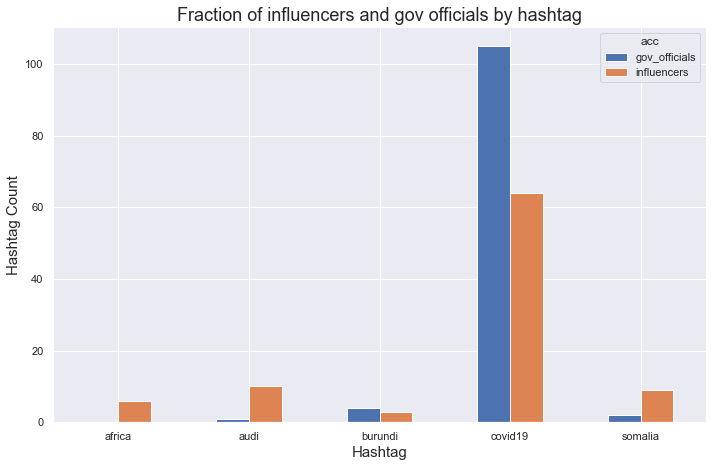

In [126]:

fig, ax = plt.subplots()
g.value_counts().unstack(1).plot(ax=ax, kind='bar', rot=0)
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
ax.set_title('Fraction of influencers and gov officials by hashtag', fontsize=18)
ax.set_xlabel('Hashtag', fontsize=15)
ax.set_ylabel('Hashtag Count',fontsize=15)



In [145]:
inf_tweets.groupby('location')['original_author'].count()

location
Addis Ababa, Ethiopia              126
Africa                             696
Amsterdam                           71
Braamfontein, Johannesburg          77
Cameroon                           103
Cape Town                          376
Cape Town, South Africa            284
Dallas, TX                           6
Doha, Qatar                         23
Evaton, Johannesburg                40
Facebook: Peter Greste              85
Geneva                             123
Golden Ivy Plaza, Karen, NBO        85
Johannesburg                       215
Johannesburg, South Africa         686
Knysna | South Africa              149
Kwa-Mhlaba Uyalingana              110
Lancaster, PA                      125
Linden, Johannesburg                82
London                             505
London, England                    151
London, UK                          61
Los Angeles                        120
Miami, FL                           15
Mogadishu | Madison | Roaming       54
Nairobi, Kenya  